### Find inverse traces
This notebook shows now to predict inverse trace using first break piking model and Random Trees.

### Task description
Some traces may be inversed because of the sensor failure. Using first break piking model and some features from traces we train RandomForest to solve the problem.

### Generated dataset discription
Let's have a look on the features that will be used for inverse traces detection. The dataset consist the following params:
* the amplitude value at the point of the first break picking
* offset
* correlation between part of traces centered by linear interpolated first break picking points.
* correlation between part of traces centered by first break picking points.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import (SeismicBatch, FieldIndex, KNNIndex,
                            seismic_plot)
from inverse_batch import InverseBatch, predict, crop_trace
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Data

Firstly have a look on the data. Let's draw some of traces and try to guess the inverse trace.

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
index = KNNIndex(name='raw', path=path_raw, extra_headers=['offset'], n_neighbors=6)

In [4]:
index = index.create_subset(index.indices[:1])
batch = (Dataset(KNNIndex((index)), InverseBatch).p
         .load(components='raw', fmt='segy')
         ).next_batch(1)

field = batch.raw[0]
mask = np.ones(len(field))
ix = np.random.choice(len(mask))
mask[ix] = -1
inv_field = np.array([trace * mask[i] for i, trace in enumerate(field)])

In [112]:
# left = ix
# right = ix + 1
seismic_plot(inv_field, cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
             figsize=(20, 5), std=0.1, xlim=(0, 6), trace_col=['b']*5, title='seismics')

ValueError: Lenght of trace_col must be equal to the number of traces.

In [28]:
print('Inverse trace is {}.'.format(ix))

Inverse trace is 5.


### Preprocessing

Firstly we load pretrained first break piking model.

In [3]:
model_path = '/notebooks/kalashnikov/geolog/models/First_break_picking/picks_modelUNet_ker5.dill'

model_ppl = Pipeline().init_model('dynamic', UNet, 'my_model',
                            config={'load' : {'path' : model_path},
                                    'build': False, 'device': 'cuda'})

model = model_ppl.get_model_by_name('my_model').model

#### Features
Here we will draw an examples of features. Two images  consist examples of traces on which correlations are considered.

In [4]:
def f(a):
    return (a - a.mean())/a.std()

offset = np.array(index.get_df(index=index.indices[0])['offset'])
field = batch.raw[0]
field = np.apply_along_axis(f, 1, field)
pred = []

for trace in field:
    tr = torch.Tensor(trace).reshape(1, 1, -1).to('cuda')
    pred.append(predict(tr, model))

NameError: name 'batch' is not defined

In [8]:
lr = LinearRegression()
data_tr = np.stack((offset, np.ones(len(offset)))).T
target = np.array(pred).reshape(-1, 1)
lr.fit(data_tr, target)
off_pred = [int(lr.predict([[off, 1]])[0][0]) for off in offset]

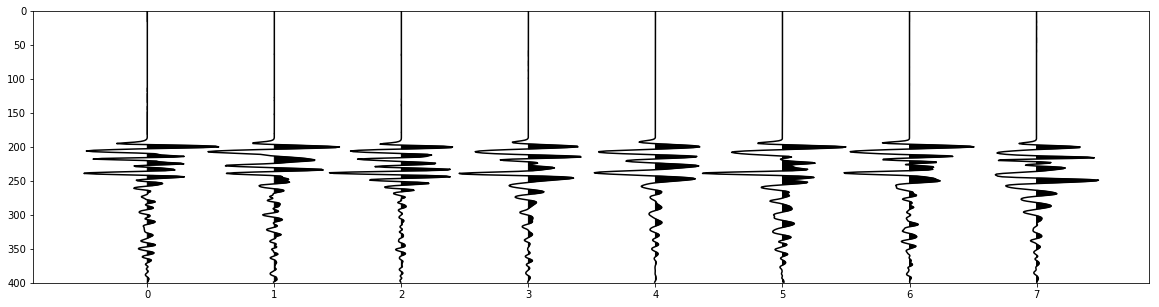

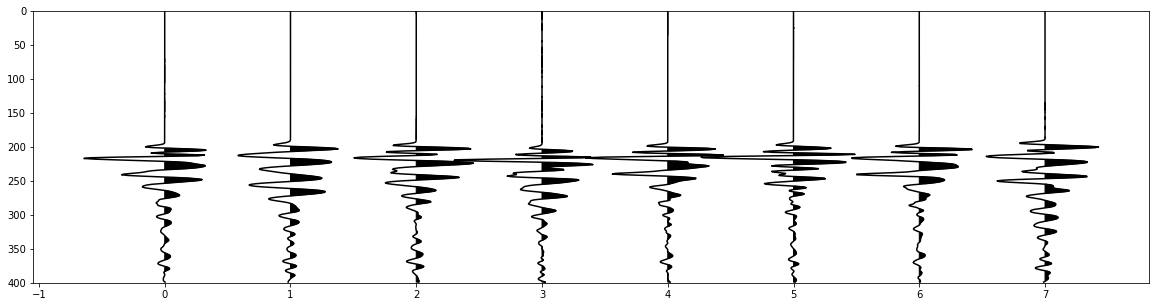

In [9]:
ix_pred = np.random.choice(range(5, len(pred)-5))
ix_pred = range(ix_pred-4, ix_pred+4)
ix_lr = np.random.choice(range(5, len(off_pred)-5))
ix_lr = range(ix_lr-4, ix_lr+4)
for type_ix, type_pred in zip([ix_pred, ix_lr], [pred, off_pred]):
    traces = []
    p = []
    for trace_ix in type_ix:
        traces.append(crop_trace(field[trace_ix], type_pred[trace_ix], 400))
        p.append(type_pred[trace_ix])
    pts = (range(len(p)), p)
    seismic_plot(np.array(traces), cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
                 figsize=(20, 5), std=0.1)

Define pipeline and generate the dataset.

In [5]:
N_NEIGH = 3
SIZE = 150
def f(a):
    return (a - a.mean())/a.std()

ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

Split dataset on train and test.

In [9]:
%%time
z = ppl.next_batch(1000)

diff = ppl.get_variable('diff')
data = np.concatenate(diff)

np.random.shuffle(data)
dataset, target = data[:,:-1], data[:,-1]
dataset = np.nan_to_num(dataset)

X_train, X_test, y_train, y_test = train_test_split(dataset, target)

CPU times: user 892 ms, sys: 56 ms, total: 948 ms
Wall time: 934 ms


Have a look on the dataset.

In [11]:
gen_name = lambda name, n: [name + '_{}'.format(i) for i in range(n)]
columns = ['amplitude', 'offset', *gen_name('of_corr_left', N_NEIGH),
           *gen_name('of_corr_right', N_NEIGH), *gen_name('of_inv_corr_left', N_NEIGH),
           *gen_name('of_inv_corr_right', N_NEIGH), *gen_name('corr_left', N_NEIGH),
           *gen_name('corr_right', N_NEIGH), 
           *gen_name('inv_corr_left', N_NEIGH), *gen_name('inv_corr_right', N_NEIGH)]
df = pd.DataFrame(X_train, columns=columns)
print('Dataset shape is: {}\n'.format(df.shape))
df.head()

Dataset shape is: (27, 26)



,amplitude,offset,of_corr_left_0,of_corr_left_1,of_corr_left_2,of_corr_right_0,of_corr_right_1,of_corr_right_2,of_inv_corr_left_0,of_inv_corr_left_1,...,corr_left_2,corr_right_0,corr_right_1,corr_right_2,inv_corr_left_0,inv_corr_left_1,inv_corr_left_2,inv_corr_right_0,inv_corr_right_1,inv_corr_right_2
0,3.102016,237.0,-0.357761,0.022628,-0.159854,0.000000,0.000000,0.000000,0.357761,-0.022628,...,-0.070120,0.000000,0.000000,0.000000,0.225589,-0.014784,0.070120,0.000000,0.000000,0.000000
1,3.318924,190.0,0.221942,-0.072556,0.053719,0.000000,0.000000,0.000000,-0.221942,0.072556,...,0.053719,0.000000,0.000000,0.000000,-0.221942,0.072556,-0.053719,0.000000,0.000000,0.000000
2,12.553547,79.0,-0.097117,0.907005,0.000000,-0.023638,0.089095,0.053719,0.097117,-0.907005,...,0.000000,-0.023638,0.089095,0.053719,0.097117,-0.907005,0.000000,0.023638,-0.089095,-0.053719
3,6.202756,106.0,-0.651517,0.350579,0.097117,0.120732,0.134158,0.000000,0.651517,-0.350579,...,0.097117,0.120732,0.134158,0.000000,0.651517,-0.350579,-0.097117,-0.120732,-0.134158,0.000000
4,5.313410,106.0,0.289399,0.023638,0.000000,-0.651517,0.238948,0.266560,-0.289399,-0.023638,...,0.000000,-0.651517,0.238948,0.266560,-0.289399,-0.023638,0.000000,0.651517,-0.238948,-0.266560


### Train Model
Using dataset generated above let's train Random Forest alghoritm.

In [12]:
tree = RandomForestClassifier(n_estimators=200, n_jobs=4)
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now let's check the model quality. 

In [13]:
pred = tree.predict(X_test)
print(classification_report(y_test, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

        0.0       0.60      0.75      0.67         4
        1.0       0.75      0.60      0.67         5

avg / total       0.68      0.67      0.67         9

Accuracy score: 0.667


And graw feature importance.

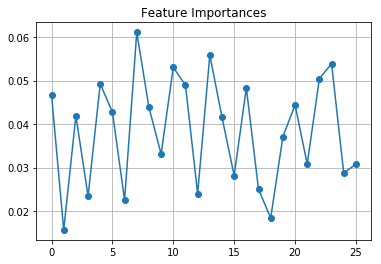

In [14]:
plt.title('Feature Importances')
plt.plot(range(len(tree.feature_importances_)),
         tree.feature_importances_, marker='o')
plt.grid()

### Predict on one field

Let's inverse some traces in one filed and check how the model will find inverse traces.

In [15]:
ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   mode='predict', size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

In [16]:
batch = ppl.next_batch(1)

pred_diff = ppl.get_variable('diff')
pred_data = np.concatenate(pred_diff)

pred_dataset, pred_target = pred_data[:, : -1], pred_data[:, -1]
pred_dataset = np.nan_to_num(pred_dataset)

pred = tree.predict(pred_dataset)

In [17]:
print(classification_report(pred_target, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(pred_target, pred)))
print('Number of inverse traces: {}'.format(sum(pred_target)))
print('Number of predict inverse traces: {}'.format(sum(pred)))
false_neg = sum(pred_target[np.where(pred_target != target)])
print('Number of missed inverse traces: {}'.format(false_neg))

             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86         3
        1.0       1.00      0.67      0.80         3

avg / total       0.88      0.83      0.83         6

Accuracy score: 0.833
Number of inverse traces: 3.0
Number of predict inverse traces: 2.0
Number of missed inverse traces: 1.0


One can notice that there are many false positive predictions and zero false negative.

### Predict on another dataset

In [24]:
path_inv = '/notebooks/egor/inverse_traces/2_prep_input_reverce_tr_check.sgy'
index_inv = (KNNIndex(name='raw', path=path_inv, extra_headers=['offset'], n_neighbors=6))

In [25]:
batch = (Dataset(KNNIndex((index_inv)), InverseBatch).p
         .load(components='raw', fmt='segy')
         ).next_batch(1)

field = batch.raw[0]

In [26]:
from torch import torch
field = np.apply_along_axis(f, 1, field)
amp = []

for trace in field:
    tr = torch.Tensor(trace).reshape(1, 1, -1).to('cuda')
    amp.append(predict(tr, model))

In [54]:
ppl = (Dataset(index_inv, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   size=SIZE, dst='diff', mode='without_inv')
         .update_variable('diff', B('diff'), mode='e')
        )

In [55]:
batch = ppl.next_batch(6)
pred_diff = ppl.get_variable('diff')
pred_data = np.concatenate(pred_diff)

pred_dataset, pred_target = pred_data[:, : -1], pred_data[:, -1]
pred_dataset = np.nan_to_num(pred_dataset)

pred = tree.predict(pred_dataset)

In [56]:
pred

array([0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1.])

In [57]:
batch.raw[0].shape

(6, 2000)

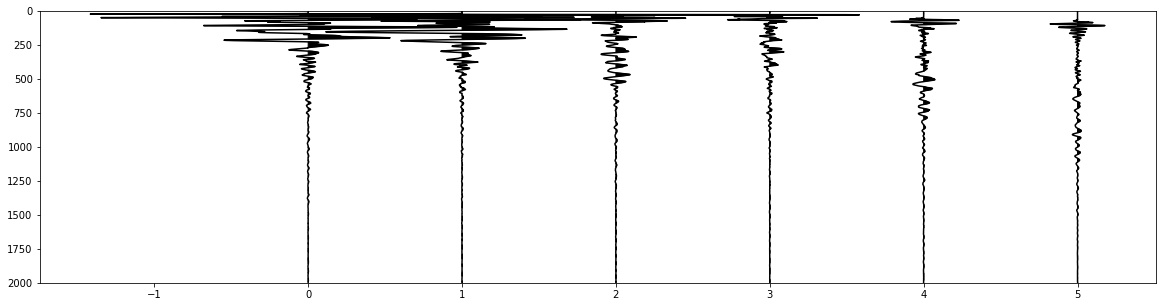

In [58]:
seismic_plot(batch.raw[0], cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
                 figsize=(20, 5), std=0.1)

In [59]:
print(sum(pred))

17.0
